# Advection with Non-Linear Sorption

This notebook provides a comprehensive guide to solving advection transport with non-linear (Freundlich) sorption using the exact analytical front-tracking method.

## Table of Contents

1. Theory
   - Governing Equation
   - Freundlich Sorption Isotherm
   - Wave Types
2. Quick Reference Tables
3. Examples
   - Example 1: Concentration Pulse with Favorable Sorption (n > 1)
   - Example 2: Multi-Step Input with Wave Interactions
   - Example 3: Concentration Dip with Unfavorable Sorption (n < 1)
4. Comparison: Effect of Sorption Type on Wave Structure
5. Notes and Limitations

## Theory

### Governing Equation

The one-dimensional advection equation with sorption in pore volume coordinates $(V, t)$:

$$\frac{\partial C_{\text{total}}}{\partial t} + Q \frac{\partial C}{\partial V} = 0$$

where:
- $C$ is dissolved concentration [mass/volume]
- $C_{\text{total}} = C + \frac{\rho_b}{\theta} s(C)$ is total concentration (dissolved + sorbed per unit pore volume)
- $Q$ is volumetric flow rate [volume/time]
- $V$ is cumulative pore volume [volume]
- $\rho_b$ is bulk density [mass/volume]
- $\theta$ is porosity [-]
- $s(C)$ is sorbed concentration [mass/mass of solid]

This is a hyperbolic conservation law with concentration-dependent wave speeds when sorption is non-linear.

### Freundlich Sorption Isotherm

The Freundlich isotherm relates sorbed and dissolved concentrations:

$$s(C) = k_f C^{1/n}$$

| Parameter | Symbol | Units | Description |
|-----------|--------|-------|-------------|
| Freundlich coefficient | $k_f$ | $(\text{m}^3/\text{kg})^{1/n}$ | Sorption capacity |
| Freundlich exponent | $n$ | - | Isotherm curvature (n=1 is linear) |
| Bulk density | $\rho_b$ | kg/m³ | Dry mass per bulk volume |
| Porosity | $\theta$ | - | Void fraction |

#### Retardation Factor

The retardation factor $R(C)$ relates pore water velocity to concentration velocity:

$$R(C) = 1 + \frac{\rho_b}{\theta} \frac{ds}{dC} = 1 + \frac{\rho_b k_f}{\theta n} C^{(1/n)-1}$$

**Key insight**: For $n \neq 1$, $R$ depends on $C$, creating concentration-dependent velocities:

$$\lambda(C) = \frac{Q}{R(C)}$$

| Regime | Condition | Effect on $R(C)$ | Physical meaning |
|--------|-----------|------------------|------------------|
| Favorable | $n > 1$ | $R$ decreases with $C$ | Higher $C$ travels faster |
| Linear | $n = 1$ | $R$ constant | All $C$ travel at same speed |
| Unfavorable | $n < 1$ | $R$ increases with $C$ | Higher $C$ travels slower |

### Wave Types

Three distinct wave structures arise in hyperbolic conservation laws:

| Wave Type | Visualization | Mathematical Form | Physical Process |
|-----------|---------------|-------------------|------------------|
| **Characteristic** | Single line in V-t space | $\frac{dV}{dt} = \lambda(C)$ | Smooth regions with constant C |
| **Shock** | Sharp front | Rankine-Hugoniot: $s = \frac{\Delta(QC)}{\Delta C_{\text{total}}}$ | Compression: fast catches slow |
| **Rarefaction** | Expanding fan | Self-similar: $R(C) = \frac{Q(t-t_0)}{V-V_0}$ | Expansion: slow follows fast |

#### Shock Velocity (Rankine-Hugoniot Condition)

For a discontinuity between $C_L$ (upstream) and $C_R$ (downstream):

$$s_{\text{shock}} = \frac{Q(C_R - C_L)}{C_{\text{total}}(C_R) - C_{\text{total}}(C_L)}$$

This ensures mass conservation across the discontinuity.

#### Entropy Condition (Lax)

Physical shocks satisfy: $\lambda(C_L) > s_{\text{shock}} > \lambda(C_R)$

Characteristics must flow *into* the shock from both sides.

## Quick Reference Tables

### Wave Formation Rules

| | Favorable ($n > 1$) | Unfavorable ($n < 1$) |
|---|---|---|
| **High C velocity** | Fast | Slow |
| **Rarefaction when** | C decreases | C increases |
| **Shock when** | C increases | C decreases |

### Breakthrough Curve Signatures

| Wave Type | Breakthrough Appearance |
|-----------|-------------------------|
| Shock | Sharp, instantaneous change |
| Rarefaction | Gradual, smooth transition |
| Characteristic | Step change at arrival time |

### Solver Properties

| Property | Value |
|----------|-------|
| Numerical dispersion | Zero |
| Mass balance precision | Machine precision (~1e-14) |
| Time stepping | Event-driven (no fixed $\Delta t$) |
| Solution type | Exact analytical |

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gwtransport.advection import infiltration_to_extraction_front_tracking_detailed
from gwtransport.fronttracking.plot import (
    plot_front_tracking_summary,
    plot_sorption_comparison,
)
from gwtransport.fronttracking.validation import verify_physics
from gwtransport.utils import compute_time_edges

plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 10

# Common parameters across all examples
bulk_density = 1500.0  # kg/m³
porosity = 0.3

## Examples

### Example 1: Concentration Pulse with Favorable Sorption ($n > 1$)

A concentration pulse ($0 \to 10 \to 0$) demonstrates both shock and rarefaction formation.

| Edge | Transition | Wave Type | Reason |
|------|------------|-----------|--------|
| Leading | $0 \to 10$ | Shock | Fast ($C=10$) catches slow ($C=0$) |
| Trailing | $10 \to 0$ | Rarefaction | Slow ($C=0$) follows fast ($C=10$) |

In [2]:
# Example 1: Setup
tedges_ex1 = pd.date_range(start="2020-01-01", periods=100, freq="D")
cin_ex1 = np.zeros(len(tedges_ex1) - 1)
cin_ex1[10:40] = 10.0  # Pulse from day 10 to 40

# Example 1 specific parameters
flow_ex1 = np.full(len(tedges_ex1) - 1, 100.0)  # m³/day
aquifer_pore_volume_ex1 = 200.0  # m³
freundlich_k_ex1 = 0.01  # (m³/kg)^(1/n)
freundlich_n_ex1 = 2.0  # n > 1 (favorable)

cout_tedges_ex1 = pd.date_range(start=tedges_ex1[0], periods=1350, freq="D")

print("Example 1: Concentration Pulse with Favorable Sorption")
print("  Inlet: 0 → 10 (day 10) → 0 (day 40)")
print(f"  Freundlich: n={freundlich_n_ex1}, k={freundlich_k_ex1}")
print(f"  Pore volume: {aquifer_pore_volume_ex1} m³")

Example 1: Concentration Pulse with Favorable Sorption
  Inlet: 0 → 10 (day 10) → 0 (day 40)
  Freundlich: n=2.0, k=0.01
  Pore volume: 200.0 m³


In [3]:
# Example 1: Simulation
cout_ex1, structure_ex1 = infiltration_to_extraction_front_tracking_detailed(
    cin=cin_ex1,
    flow=flow_ex1,
    tedges=tedges_ex1,
    cout_tedges=cout_tedges_ex1,
    aquifer_pore_volumes=[aquifer_pore_volume_ex1],
    freundlich_k=freundlich_k_ex1,
    freundlich_n=freundlich_n_ex1,
    bulk_density=bulk_density,
    porosity=porosity,
)

print(
    f"Results: {structure_ex1[0]['n_events']} events | "
    f"{structure_ex1[0]['n_shocks']} shocks | "
    f"{structure_ex1[0]['n_rarefactions']} rarefactions | "
    f"First arrival: {structure_ex1[0]['t_first_arrival']:.1f} days"
)

results_ex1 = verify_physics(structure_ex1[0], cout_ex1, cout_tedges_ex1, cin_ex1, verbose=True)
print(f"\n{results_ex1['summary']}")

Results: 3 events | 1 shocks | 1 rarefactions | First arrival: 27.8 days

✓ All 8 physics checks passed


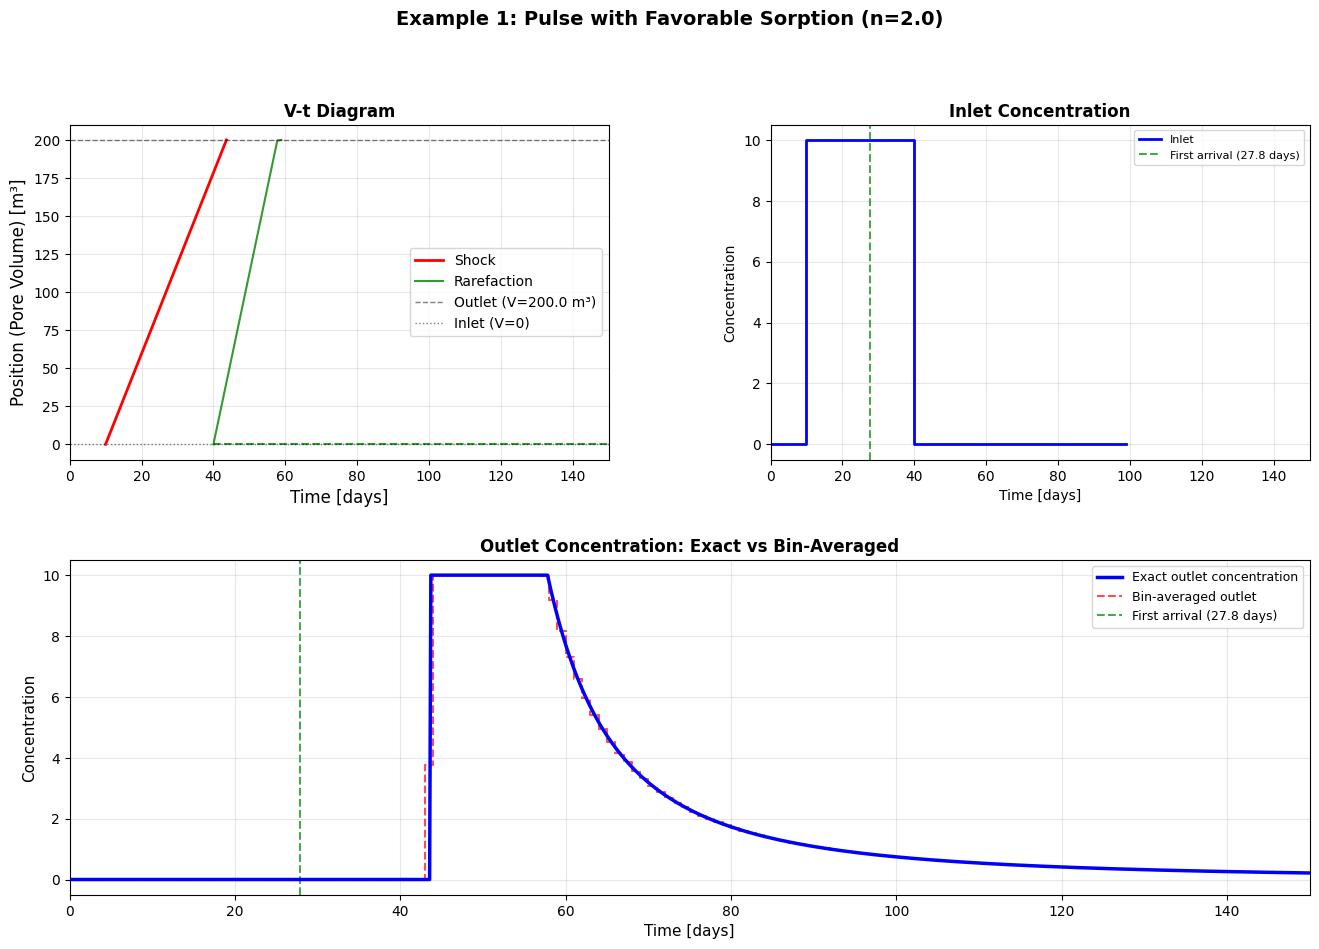

In [4]:
# Example 1: Visualization
axes_ex1 = plot_front_tracking_summary(
    structure_ex1[0],
    tedges_ex1,
    cin_ex1,
    cout_tedges_ex1,
    cout_ex1,
    t_max=150,
    title="Example 1: Pulse with Favorable Sorption (n=2.0)",
)
plt.show()

**Interpretation**: The V-t diagram shows the shock (red) on the leading edge and the rarefaction fan (green) on the trailing edge. The breakthrough curve exhibits a sharp rise followed by a gradual decline.

### Example 2: Multi-Step Input with Wave Interactions

Multiple concentration increases ($0 \to 10 \to 15 \to 20$) create interacting shock waves.

| Step | Transition | Wave | Interaction Potential |
|------|------------|------|----------------------|
| 1 | $0 \to 10$ | Shock | Base shock |
| 2 | $10 \to 15$ | Shock | Catches Step 1 (faster) |
| 3 | $15 \to 20$ | Shock | Catches Steps 1-2 (fastest) |

In [5]:
# Example 2: Setup
tedges_ex2 = pd.date_range(start="2020-01-01", periods=101, freq="D")
cin_ex2 = np.zeros(len(tedges_ex2) - 1)
cin_ex2[10:50] = 10.0  # Step 1
cin_ex2[25:] = 15.0  # Step 2
cin_ex2[30:] = 20.0  # Step 3
cin_ex2[-1] = 0.0  # Return to baseline

# Example 2 specific parameters
flow_ex2 = np.full(len(tedges_ex2) - 1, 100.0)
aquifer_pore_volume_ex2 = 500.0
freundlich_k_ex2 = 0.01
freundlich_n_ex2 = 2.0

cout_tedges_ex2 = pd.date_range(start=tedges_ex2[0], periods=151, freq="D")

print("Example 2: Multi-Step Concentration Increases")
print("  Step 1 (day 10): 0 → 10")
print("  Step 2 (day 25): 10 → 15")
print("  Step 3 (day 30): 15 → 20")
print(f"  Pore volume: {aquifer_pore_volume_ex2} m³")

Example 2: Multi-Step Concentration Increases
  Step 1 (day 10): 0 → 10
  Step 2 (day 25): 10 → 15
  Step 3 (day 30): 15 → 20
  Pore volume: 500.0 m³


In [6]:
# Example 2: Simulation
cout_ex2, structure_ex2 = infiltration_to_extraction_front_tracking_detailed(
    cin=cin_ex2,
    flow=flow_ex2,
    tedges=tedges_ex2,
    cout_tedges=cout_tedges_ex2,
    aquifer_pore_volumes=[aquifer_pore_volume_ex2],
    freundlich_k=freundlich_k_ex2,
    freundlich_n=freundlich_n_ex2,
    bulk_density=bulk_density,
    porosity=porosity,
)

print(
    f"Results: {structure_ex2[0]['n_events']} events | "
    f"{structure_ex2[0]['n_shocks']} shocks | "
    f"{structure_ex2[0]['n_rarefactions']} rarefactions | "
    f"First arrival: {structure_ex2[0]['t_first_arrival']:.1f} days"
)

results_ex2 = verify_physics(structure_ex2[0], cout_ex2, cout_tedges_ex2, cin_ex2, verbose=True)
print(f"\n{results_ex2['summary']}")

Results: 7 events | 5 shocks | 1 rarefactions | First arrival: 54.5 days

✓ All 8 physics checks passed


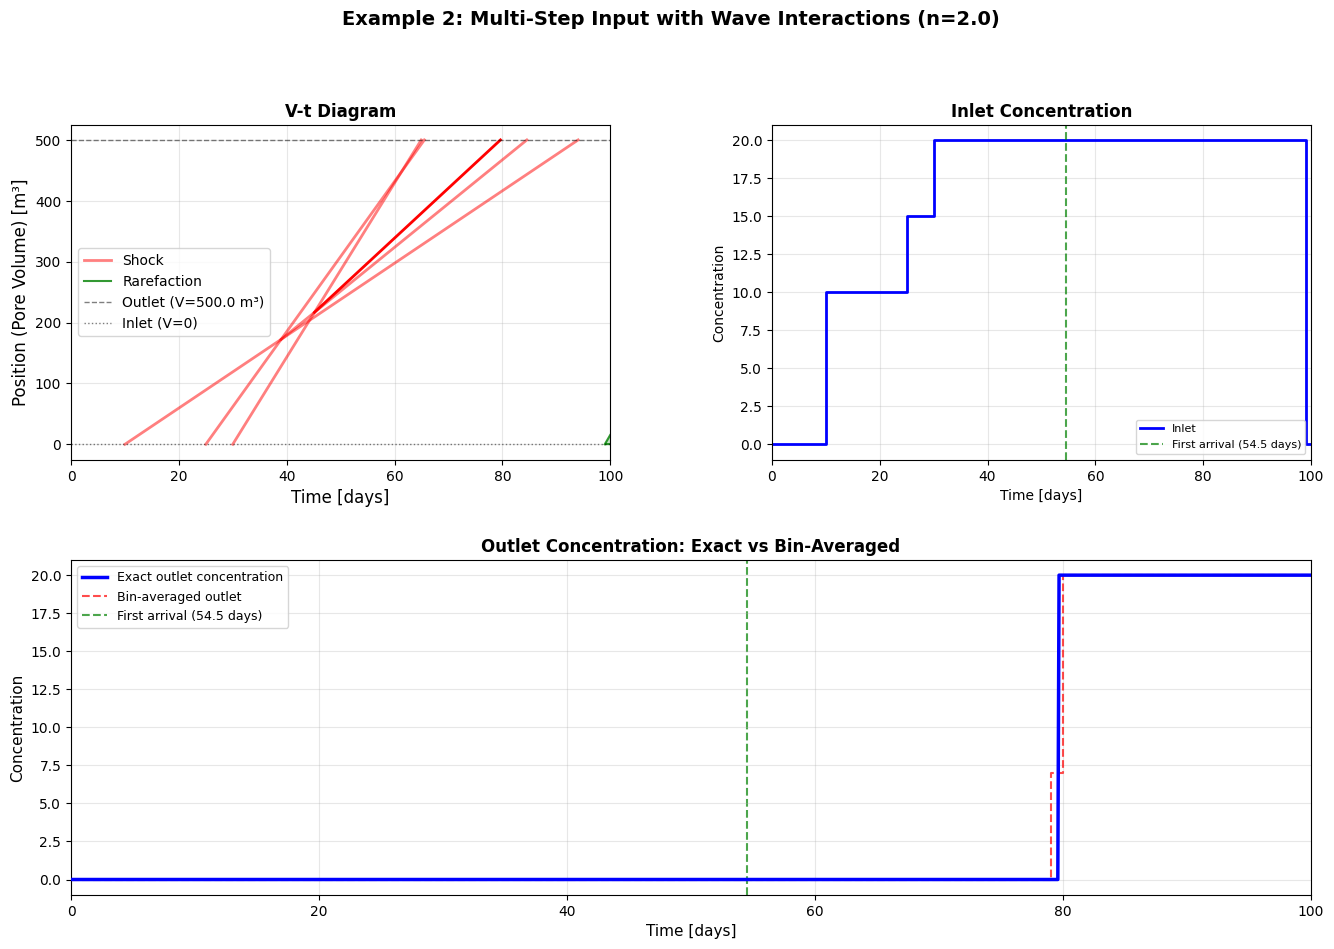

In [7]:
# Example 2: Visualization
axes_ex2 = plot_front_tracking_summary(
    structure_ex2[0],
    tedges_ex2,
    cin_ex2,
    cout_tedges_ex2,
    cout_ex2,
    t_max=100,
    show_events=True,
    show_inactive=True,
    title="Example 2: Multi-Step Input with Wave Interactions (n=2.0)",
)
plt.show()

**Interpretation**: Event markers (×) show where faster shocks catch slower ones. The final breakthrough reaches $C=20$, the maximum inlet concentration.

### Example 3: Concentration Dip with Unfavorable Sorption ($n < 1$)

With $n < 1$, the physics *reverses*: higher concentrations travel slower.

| Property | $n > 1$ (Favorable) | $n < 1$ (Unfavorable) |
|----------|---------------------|----------------------|
| High C velocity | Fast | Slow |
| Rarefaction from | C decrease | C increase |
| Shock from | C increase | C decrease |

To demonstrate rarefactions with $n < 1$, we use a **concentration dip** ($10 \to 2 \to 10$):

| Edge | Transition | Wave Type | Reason |
|------|------------|-----------|--------|
| Leading | $10 \to 2$ | Rarefaction | Fast ($C=2$) outruns slow ($C=10$) |
| Trailing | $2 \to 10$ | Shock | Slow ($C=10$) catches fast ($C=2$) |

In [8]:
# Example 3: Setup
dates_ex3 = pd.date_range(start="2020-01-01", periods=201, freq="D")
tedges_ex3 = compute_time_edges(tedges=None, tstart=None, tend=dates_ex3, number_of_bins=len(dates_ex3))

cin_ex3 = np.full(len(dates_ex3), 10.0)  # Baseline
cin_ex3[:2] = 0.0  # Initial condition
cin_ex3[40:100] = 2.0  # Dip
cin_ex3[-1] = 0.0  # Explicit end for mass balance

# Example 3 specific parameters
flow_ex3 = np.full(len(dates_ex3), 100.0)
aquifer_pore_volume_ex3 = 200.0
freundlich_k_ex3 = 0.001
freundlich_n_ex3 = 0.7  # n < 1 (unfavorable)

cout_dates_ex3 = pd.date_range(start=dates_ex3[0], periods=300, freq="D")
cout_tedges_ex3 = compute_time_edges(tedges=None, tstart=None, tend=cout_dates_ex3, number_of_bins=len(cout_dates_ex3))

print("Example 3: Concentration Dip with Unfavorable Sorption")
print("  Inlet: 10 → 2 (day 40) → 10 (day 100) → 0 (day 200)")
print(f"  Freundlich: n={freundlich_n_ex3} (n < 1), k={freundlich_k_ex3}")
print("  Physics: High C = High retardation (SLOW)")

Example 3: Concentration Dip with Unfavorable Sorption
  Inlet: 10 → 2 (day 40) → 10 (day 100) → 0 (day 200)
  Freundlich: n=0.7 (n < 1), k=0.001
  Physics: High C = High retardation (SLOW)


In [9]:
# Example 3: Simulation
cout_ex3, structure_ex3 = infiltration_to_extraction_front_tracking_detailed(
    cin=cin_ex3,
    flow=flow_ex3,
    tedges=tedges_ex3,
    cout_tedges=cout_tedges_ex3,
    aquifer_pore_volumes=[aquifer_pore_volume_ex3],
    freundlich_k=freundlich_k_ex3,
    freundlich_n=freundlich_n_ex3,
    bulk_density=bulk_density,
    porosity=porosity,
)

print(
    f"Results: {structure_ex3[0]['n_events']} events | "
    f"{structure_ex3[0]['n_shocks']} shocks | "
    f"{structure_ex3[0]['n_rarefactions']} rarefactions | "
    f"First arrival: {structure_ex3[0]['t_first_arrival']:.1f} days"
)

results_ex3 = verify_physics(structure_ex3[0], cout_ex3, cout_tedges_ex3, cin_ex3, verbose=True)
print(f"\n{results_ex3['summary']}")

Results: 8 events | 2 shocks | 2 rarefactions | First arrival: 42.3 days

✓ All 8 physics checks passed


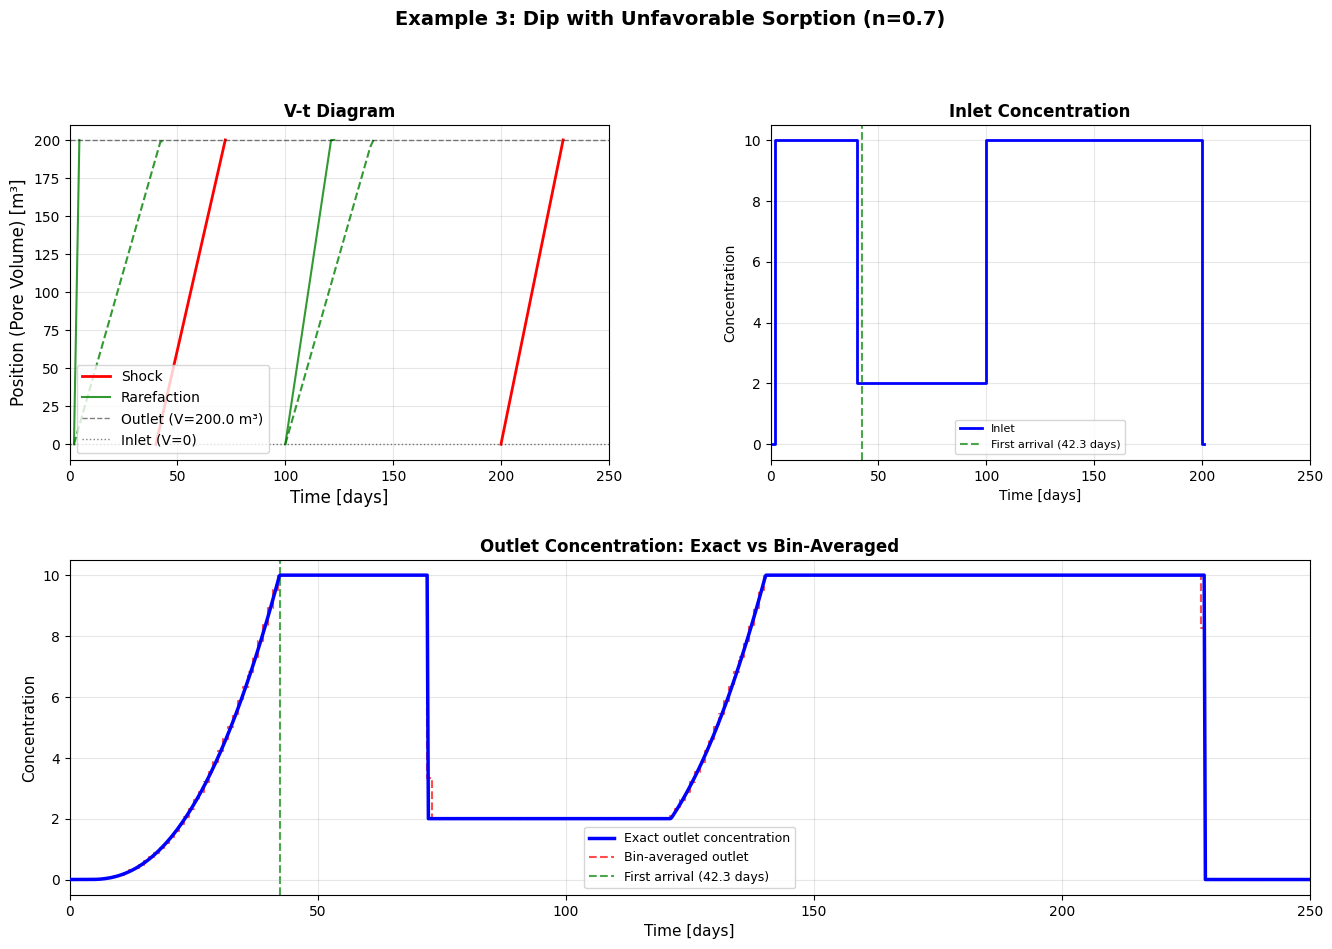

In [10]:
# Example 3: Visualization
axes_ex3 = plot_front_tracking_summary(
    structure_ex3[0],
    tedges_ex3,
    cin_ex3,
    cout_tedges_ex3,
    cout_ex3,
    t_max=250,
    title="Example 3: Dip with Unfavorable Sorption (n=0.7)",
)
plt.show()

**Interpretation**: This is the **mirror image** of Example 1. The rarefaction fan (green) appears on the *leading* edge ($10 \to 2$), while the shock (red) appears on the *trailing* edge ($2 \to 10$).

## Comparison: Effect of Sorption Type on Wave Structure

The same inlet pattern produces **different wave structures** depending on the sorption type.

| Inlet | Sorption | Leading Edge | Trailing Edge |
|-------|----------|--------------|---------------|
| Pulse ($0 \to C \to 0$) | Favorable ($n>1$) | Shock | Rarefaction |
| Pulse ($0 \to C \to 0$) | Unfavorable ($n<1$) | Rarefaction | Shock |
| Dip ($C \to c \to C$) | Favorable ($n>1$) | Rarefaction | Shock |
| Dip ($C \to c \to C$) | Unfavorable ($n<1$) | Shock | Rarefaction |

In [11]:
# Cross-comparison: Run pulse with unfavorable and dip with favorable
print("Running pulse inlet with unfavorable sorption (n=0.7)...")
_, structure_pulse_unfav = infiltration_to_extraction_front_tracking_detailed(
    cin=cin_ex1,
    flow=flow_ex1,
    tedges=tedges_ex1,
    cout_tedges=cout_tedges_ex1,
    aquifer_pore_volumes=[aquifer_pore_volume_ex1],
    freundlich_k=freundlich_k_ex3,
    freundlich_n=freundlich_n_ex3,
    bulk_density=bulk_density,
    porosity=porosity,
)

print("Running dip inlet with favorable sorption (n=2.0)...")
_, structure_dip_fav = infiltration_to_extraction_front_tracking_detailed(
    cin=cin_ex3,
    flow=flow_ex3,
    tedges=tedges_ex3,
    cout_tedges=cout_tedges_ex3,
    aquifer_pore_volumes=[aquifer_pore_volume_ex3],
    freundlich_k=freundlich_k_ex1,
    freundlich_n=freundlich_n_ex1,
    bulk_density=bulk_density,
    porosity=porosity,
)

Running pulse inlet with unfavorable sorption (n=0.7)...
Running dip inlet with favorable sorption (n=2.0)...


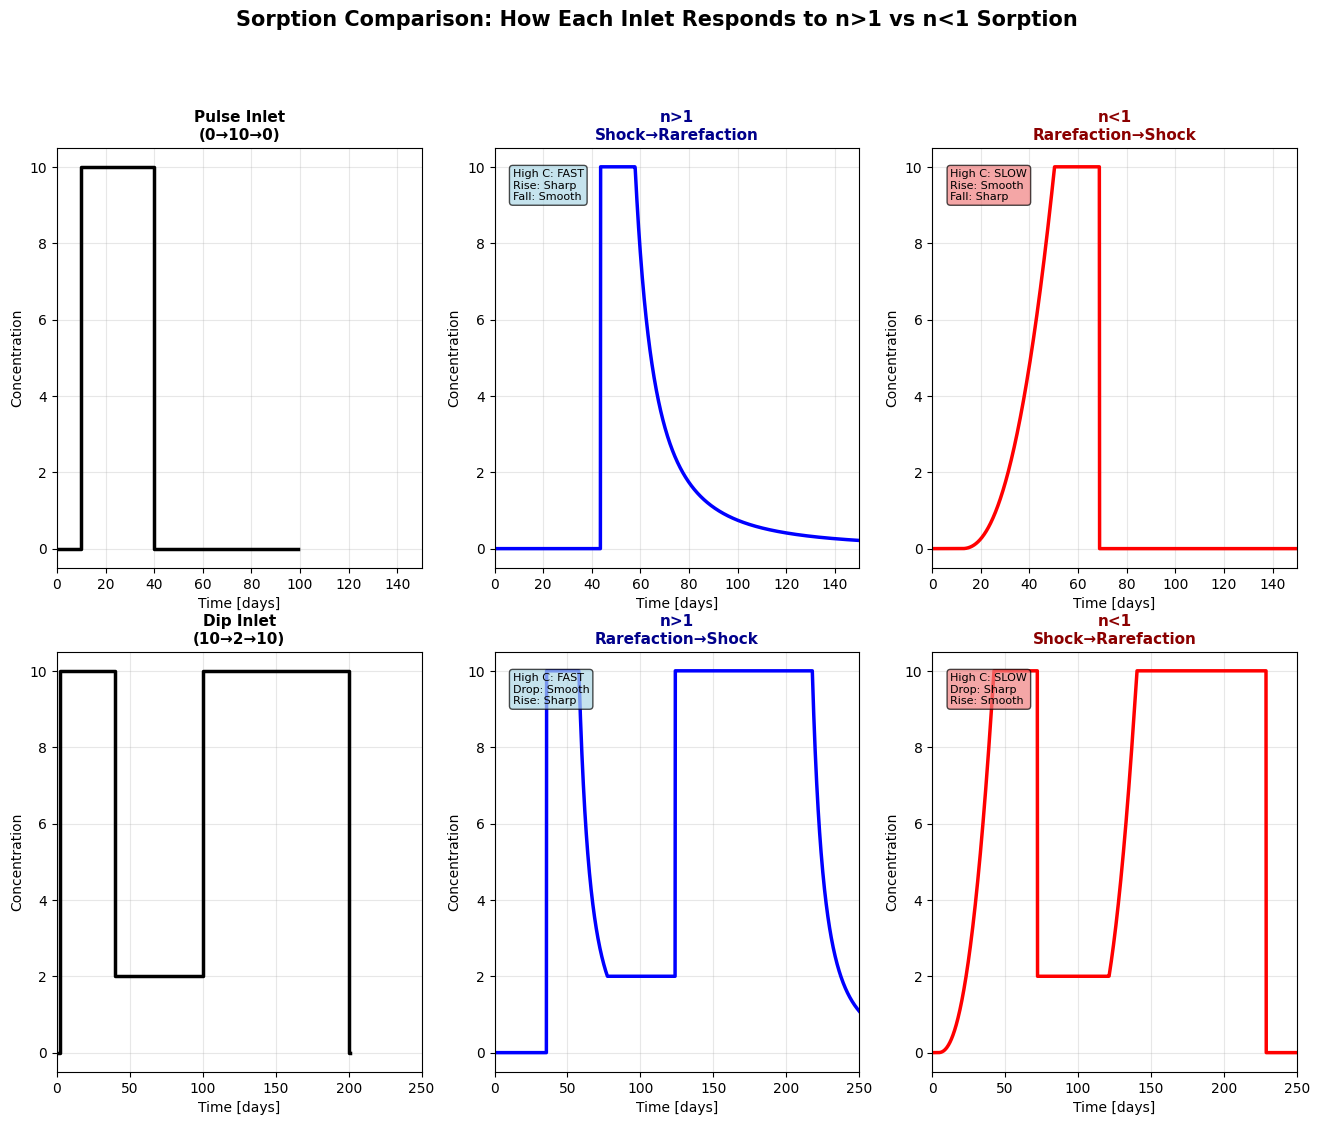

In [12]:
# Comparison plot
fig_comp, axes_comp = plot_sorption_comparison(
    pulse_favorable_structure=structure_ex1[0],
    pulse_unfavorable_structure=structure_pulse_unfav[0],
    pulse_tedges=tedges_ex1,
    pulse_cin=cin_ex1,
    dip_favorable_structure=structure_dip_fav[0],
    dip_unfavorable_structure=structure_ex3[0],
    dip_tedges=tedges_ex3,
    dip_cin=cin_ex3,
    t_max_pulse=150,
    t_max_dip=250,
)
plt.show()

## Notes and Limitations

Only a single compound can be simulated at a time and no chemical reactions are considered. Furthermore, only Freundlich sorption is currently supported, so there is for example no saturation limit. Other isotherms could be implemented without too much effort.

The solver is exact analytical with no numerical dispersion or tolerance-based approximations and is event-driven to track wave interactions precisely. It is mass-conservative to machine precision (~1e-14) and performs physics verification (entropy conditions, arrival times, concentration bounds).

### References

For implementation details, see:
- :mod:`gwtransport.fronttracking.math`: Sorption models and shock/characteristic velocity
- :mod:`gwtransport.fronttracking.waves`: Wave classes (Characteristic, Shock, Rarefaction)
- :mod:`gwtransport.fronttracking.solver`: Event-driven simulation engine
- :func:`~gwtransport.advection.infiltration_to_extraction_front_tracking`: High-level API